In [2]:
! git clone https://github.com/rpathak38/DL_Proj

Cloning into 'DL_Proj'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 86 (delta 40), reused 60 (delta 18), pack-reused 0
Receiving objects: 100% (86/86), 13.38 MiB | 44.07 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [1]:
cd DL_Proj

/root/GATech/cs7643/ami_proj/DL_Proj


In [2]:
%load_ext autoreload
%autoreload 1
import urllib.request
import tarfile
import numpy as np
import random
import os
import torch
from PIL import Image
from torchvision import transforms
import zipfile
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from unet import UNet
from tqdm import tqdm
from metrics_loss import dice_index, class_balanced_focal_ce_loss,calculate_iou,pixel_acc

In [3]:
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

# 5. If you are using CUDA, set also the seed for it and enable deterministic behavior
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU.
    # Below two lines ensure deterministic behavior, but may lead to slower training
    # due to the need to find algorithms that have deterministic behavior.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
# Check if CUDA is available
# Regardless of whether or not you are using GPU create the no gpu environment for now
is_cuda_available = torch.cuda.is_available()

# Print the status of CUDA availability
print("CUDA Available:", is_cuda_available)

# Set the device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if is_cuda_available else "cpu")

# Print the device being used
print("Using device:", device)

CUDA Available: True
Using device: cuda


In [6]:
data_dir = "data"
aug_data_dir = "sbd_dat_mat"
large_dataset = False # set to false if you want small dataset (0k images vs 10k images)
download = True # specify true if you want to download data

In [7]:
# if download is True:
#     os.makedirs(data_dir, exist_ok=True)

#     voc_url = "http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar"
#     voc_name = "pascal_voc.tar"
#     voc_name = os.path.join(data_dir, voc_name)

#     urllib.request.urlretrieve(voc_url, voc_name)

#     with tarfile.open(voc_name) as tar:
#         tar.extractall(path=data_dir)

In [8]:
# # Augmentations dataset. This is a large dataset. Don't download unless you are planning on doing full training.
# if large_dataset is True:
#     aug_data_dir = "sbd_dat_mat"
#     os.makedirs(aug_data_dir, exist_ok=True)

#     aug_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz"
#     aug_name = os.path.join(aug_data_dir, 'sbd_aug.tar')

#     # Downloading the file from the URL
#     urllib.request.urlretrieve(aug_url, aug_name)

#     with tarfile.open(aug_name) as tar:
#         tar.extractall(path=aug_data_dir)

In [9]:
from data_loader import pascalVOCLoader
from augmentations import *

# motivation for cropping instead of resizing: https://github.com/VainF/DeepLabV3Plus-Pytorch
img_size = 256 # pass in your image size
resize = "resize" # choose resizing method, "random_crop" which takes a random crop from the image, or use "resize" which scales the image down
# random crop preserves pixel level info while losing the whole picture, while resize keeps the whole picture, but may distort pixel level info

if resize == "random_crop":
    aug_list = Compose([RandomCrop(img_size)])
    img_size = "same"
else:
    aug_list = Compose([])

pascal_original = os.path.join(data_dir, "VOCdevkit/VOC2012")
if large_dataset is True:
    pascal_augment = os.path.join(aug_data_dir, "benchmark_RELEASE")
    split_train = "train_aug"
    split_val = "train_aug_val"
else:
    pascal_augment = None
    split_train = "train"
    split_val = "val"
train_dataset = pascalVOCLoader(pascal_original, pascal_augment, split=split_train, is_transform=True, img_size=img_size, augmentations=aug_list)
val_dataset = pascalVOCLoader(pascal_original, pascal_augment, split=split_val, is_transform=True, img_size=img_size, augmentations=aug_list)
# After this cell runs, switch to gpu environment if desired. Comment out dataset download code before running (above two cells).

Using small dataset (Pascal VOC)
Using small dataset (Pascal VOC)


In [10]:
freq = torch.zeros(len(train_dataset.get_pascal_labels()))
total = torch.zeros(1)
for img, mask in train_dataset:
    indices, counts = mask.unique(return_counts=True)
    for index, count in zip(indices, counts):
        freq[index] += count
    total += sum(counts)
freq = freq / total
print(freq)

tensor([0.7490, 0.0070, 0.0028, 0.0082, 0.0059, 0.0058, 0.0169, 0.0136, 0.0256,
        0.0110, 0.0080, 0.0124, 0.0161, 0.0089, 0.0108, 0.0457, 0.0062, 0.0085,
        0.0138, 0.0152, 0.0086])


In [11]:
class_weights = 1/freq
print(class_weights)

tensor([  1.3350, 142.0824, 354.8448, 121.6011, 170.6002, 173.5987,  59.1748,
         73.4235,  39.0592,  91.2982, 124.5666,  80.3877,  62.1089, 112.9127,
         92.2138,  21.8766, 161.7523, 118.2453,  72.5260,  65.9312, 116.1235])


In [12]:
from torch.utils.data import DataLoader

# DataLoader parameters
batch_size = 8  # You can adjust this depending on your GPU memory
shuffle = True   # Shuffles the dataset at every epoch
num_workers = 4  # Number of worker threads for loading data

# Create the DataLoaders for our training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [13]:
vis_length = 5
imgs = []
masks = []
for img, mask in train_loader:
    imgs.append(train_dataset.unnormalize(img[0]))
    print(mask[0].unique())
    print(mask[0].shape)
    mask_decoded = train_dataset.decode_segmap(mask[0].numpy())
    masks.append(torch.tensor(mask_decoded).permute(2, 0, 1))
    if len(imgs) == vis_length:
        break
print(imgs[0].shape)
print(masks[0].shape)

tensor([ 0, 19])
torch.Size([256, 256])
tensor([ 0, 12, 15, 17])
torch.Size([256, 256])
tensor([0, 1])
torch.Size([256, 256])
tensor([ 0,  7, 15])
torch.Size([256, 256])
tensor([ 0, 13])
torch.Size([256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


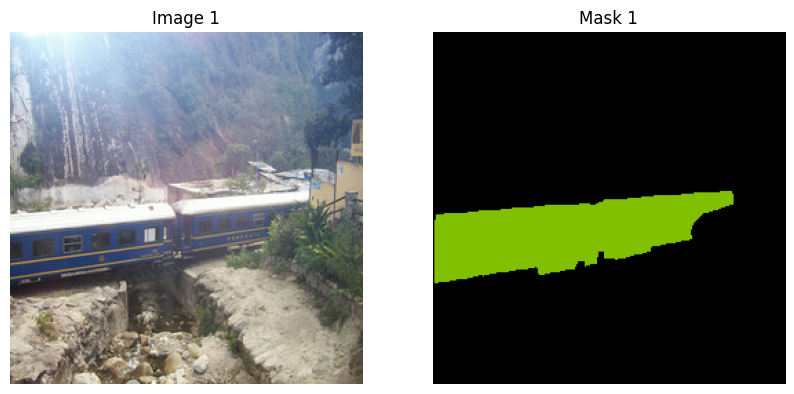

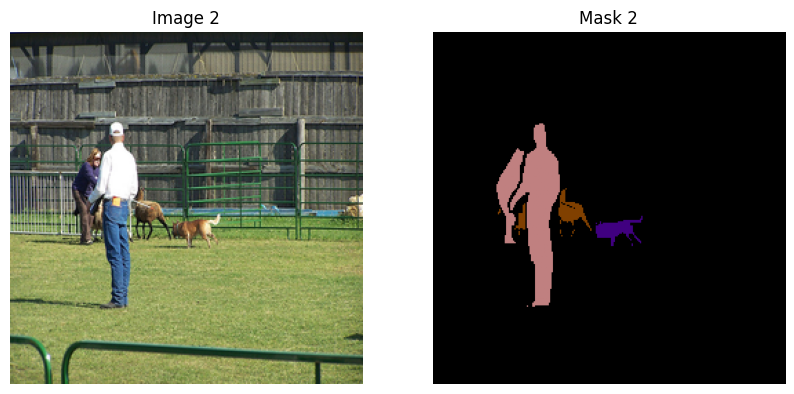

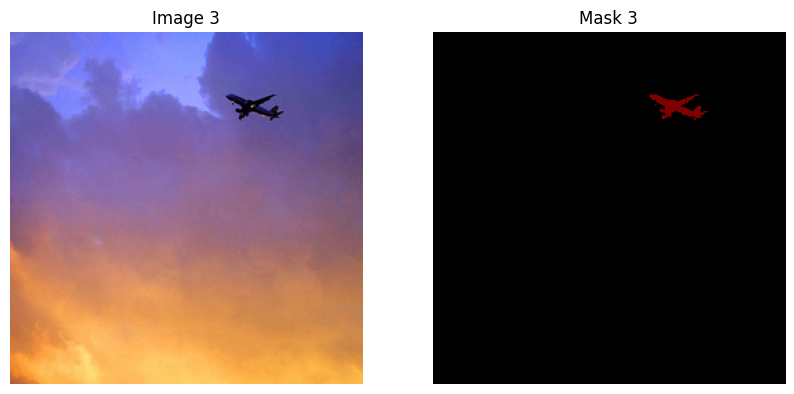

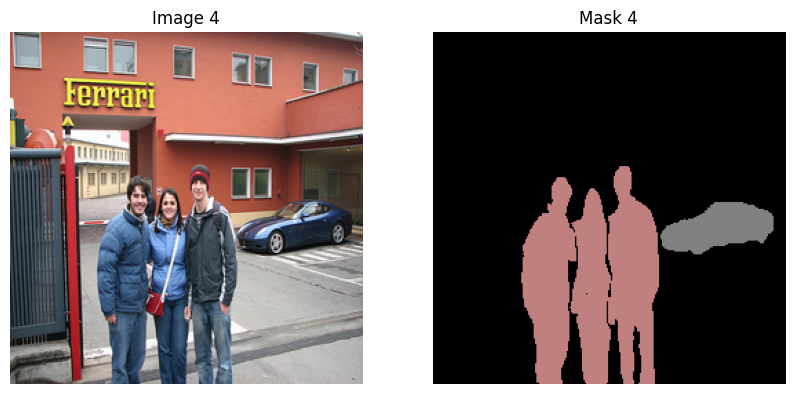

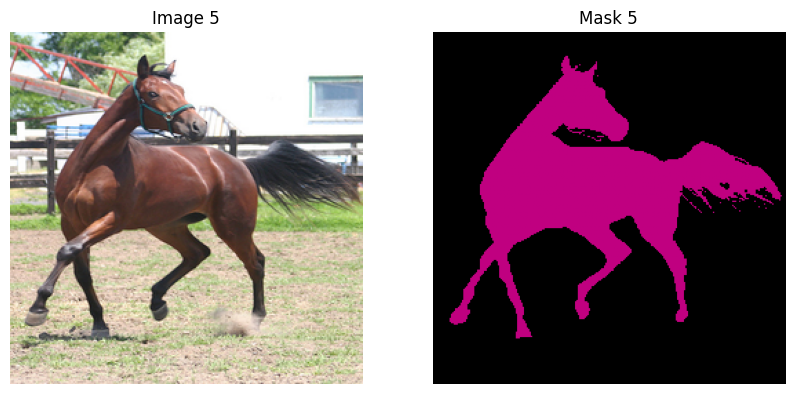

In [14]:
def visualize_image_and_mask_tensors(image_tensors, mask_tensors):
    """
    Visualize lists of image tensors and their corresponding mask tensors as regular images.

    Parameters:
        image_tensors (list of torch.Tensor): The list of image tensors to visualize.
        mask_tensors (list of torch.Tensor): The list of mask tensors to visualize.
    """
    for i, (image_tensor, mask_tensor) in enumerate(zip(image_tensors, mask_tensors)):
        # Convert the image tensor to numpy and change to HWC format for visualization
        image_np = image_tensor.permute(1, 2, 0).numpy()

        # Convert the mask tensor to numpy and change to HWC format for visualization
        mask_np = mask_tensor.permute(1, 2, 0).numpy()

        # Display the image and the mask side by side
        plt.figure(figsize=(10, 5))

        # Display the image
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title(f'Image {i+1}')
        plt.axis('off')

        # Display the mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask_np)
        plt.title(f'Mask {i+1}')
        plt.axis('off')

        plt.show()

# For testing, let's use the same image tensors and mask tensors as regular three-channel images
# We'll use the previously defined image_tensors and create new mask_tensors with 3 channels
mask_tensors = [torch.rand(3, 100, 100), torch.rand(3, 100, 100)]

# Test the function
visualize_image_and_mask_tensors(imgs, masks)

In [17]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)

# Initialize the model
model = UNet(3, 21, [64, 128, 256, 512])

# Move the model to the CUDA device if available
model = model.to(device)
class_weights = 1/freq
class_weights = class_weights.to(device)

epochs = 30
lr = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

Using device: cuda


In [18]:
# Training and validation code
for epoch in range(epochs):
    print(f"EPOCH {epoch}:")
    model.train()
    batch_loss = batch_acc = batch_iou=batch_pacc=0.0

    for img, mask in tqdm(train_loader, desc=f"Training Loop, Epoch: {epoch}"):
        # Move data to CUDA
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        outs = model(img)
        loss = class_balanced_focal_ce_loss(outs, mask, weights=class_weights, gamma=2)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            outs=torch.argmax(outs,dim=1)
            accuracy = dice_index(outs, mask)
            iou=calculate_iou(outs,mask)
            pacc=pixel_acc(outs,mask)
            batch_loss += loss.item()
            batch_acc += accuracy.item()
            batch_iou+=iou
            batch_pacc+=pacc

    batch_loss /= len(train_loader)
    batch_acc /= len(train_loader)
    batch_iou/=len(train_loader)
    batch_pacc/=len(train_loader)
    print(f"Training loss: {batch_loss}, Training accuracy: {batch_pacc}, DICE:{batch_acc} ,IOU: {batch_iou}")
    model.eval()
    val_loss = val_acc = val_iou=val_pacc=0.0

    with torch.no_grad():
        for img, mask in tqdm(val_loader, desc=f"Validation Loop, Epoch: {epoch}"):
            # Move data to CUDA
            img, mask = img.to(device), mask.to(device)

            outs = model(img)
            loss = class_balanced_focal_ce_loss(outs, mask, weights=class_weights, gamma=2)
            outs=torch.argmax(outs,dim=1)
            iou=calculate_iou(outs,mask)
            pacc=pixel_acc(outs,mask)
            accuracy = dice_index(outs, mask)
            val_loss += loss.item()
            val_acc += accuracy.item()
            val_iou+=iou
            val_pacc+=pacc

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_iou/=len(val_loader)
    val_pacc/=len(val_loader)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_pacc},DICE:{val_acc},IOU: {val_iou}")

EPOCH 0:


Training Loop, Epoch: 0: 100%|██████████| 183/183 [00:54<00:00,  3.35it/s]


Training loss: 56.364095416876786, Training accuracy: 0.0876881331205368, DICE:0.5157517835579283 ,IOU: 0.25787589177896414


Validation Loop, Epoch: 0: 100%|██████████| 182/182 [00:18<00:00,  9.79it/s]


Validation loss: 57.10664863376827, Validation accuracy: 0.11148421466350555,DICE:0.534682113308828,IOU: 0.267341056654414
EPOCH 1:


Training Loop, Epoch: 1: 100%|██████████| 183/183 [00:54<00:00,  3.35it/s]


Training loss: 55.07223711899721, Training accuracy: 0.15704548358917236, DICE:0.5371479026443972 ,IOU: 0.2685739513221986


Validation Loop, Epoch: 1: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 56.18801589588543, Validation accuracy: 0.15400098264217377,DICE:0.5328718087339139,IOU: 0.26643590436695697
EPOCH 2:


Training Loop, Epoch: 2: 100%|██████████| 183/183 [00:54<00:00,  3.35it/s]


Training loss: 54.37497039961685, Training accuracy: 0.19642764329910278, DICE:0.5515220459204554 ,IOU: 0.2757610229602277


Validation Loop, Epoch: 2: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 55.48437572311569, Validation accuracy: 0.2537103295326233,DICE:0.5890203179730163,IOU: 0.2945101589865082
EPOCH 3:


Training Loop, Epoch: 3: 100%|██████████| 183/183 [00:54<00:00,  3.35it/s]


Training loss: 53.87940460997201, Training accuracy: 0.22320768237113953, DICE:0.5659796300807286 ,IOU: 0.2829898150403643


Validation Loop, Epoch: 3: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 54.98136102236234, Validation accuracy: 0.22302904725074768,DICE:0.5775924357739124,IOU: 0.2887962178869562
EPOCH 4:


Training Loop, Epoch: 4: 100%|██████████| 183/183 [00:54<00:00,  3.35it/s]


Training loss: 53.635330325267354, Training accuracy: 0.22787445783615112, DICE:0.5737547157892112 ,IOU: 0.2868773578946056


Validation Loop, Epoch: 4: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 54.58053253509186, Validation accuracy: 0.23898349702358246,DICE:0.5948840282284297,IOU: 0.29744201411421484
EPOCH 5:


Training Loop, Epoch: 5: 100%|██████████| 183/183 [00:54<00:00,  3.35it/s]


Training loss: 53.340219883319456, Training accuracy: 0.2506016790866852, DICE:0.5837934159678839 ,IOU: 0.29189670798394196


Validation Loop, Epoch: 5: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 54.502198816655756, Validation accuracy: 0.15623162686824799,DICE:0.5531501844525337,IOU: 0.27657509222626686
EPOCH 6:


Training Loop, Epoch: 6: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 53.12843566644387, Training accuracy: 0.2399357408285141, DICE:0.5760276333881857 ,IOU: 0.2880138166940929


Validation Loop, Epoch: 6: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 54.09724960746346, Validation accuracy: 0.23648661375045776,DICE:0.593815993312951,IOU: 0.2969079966564755
EPOCH 7:


Training Loop, Epoch: 7: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 52.72612298642351, Training accuracy: 0.2497478872537613, DICE:0.5846554485500836 ,IOU: 0.2923277242750418


Validation Loop, Epoch: 7: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 53.99835776234721, Validation accuracy: 0.2805929481983185,DICE:0.6056426653003955,IOU: 0.3028213326501977
EPOCH 8:


Training Loop, Epoch: 8: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 52.55247623672902, Training accuracy: 0.2570076584815979, DICE:0.5828655071434428 ,IOU: 0.2914327535717214


Validation Loop, Epoch: 8: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 53.65324566390488, Validation accuracy: 0.2390073835849762,DICE:0.5920875851105858,IOU: 0.2960437925552929
EPOCH 9:


Training Loop, Epoch: 9: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 52.32208915877212, Training accuracy: 0.27072930335998535, DICE:0.5943770605683978 ,IOU: 0.2971885302841989


Validation Loop, Epoch: 9: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 53.72385354094453, Validation accuracy: 0.16812452673912048,DICE:0.5545953243643373,IOU: 0.27729766218216867
EPOCH 10:


Training Loop, Epoch: 10: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 52.16239768690099, Training accuracy: 0.2633443772792816, DICE:0.5895652058508878 ,IOU: 0.2947826029254439


Validation Loop, Epoch: 10: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 53.65440858065427, Validation accuracy: 0.20997808873653412,DICE:0.5702428283927204,IOU: 0.2851214141963602
EPOCH 11:


Training Loop, Epoch: 11: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 52.019614391639585, Training accuracy: 0.273904412984848, DICE:0.5979673591304998 ,IOU: 0.2989836795652499


Validation Loop, Epoch: 11: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 53.45201556237189, Validation accuracy: 0.26298993825912476,DICE:0.6015137352131226,IOU: 0.3007568676065613
EPOCH 12:


Training Loop, Epoch: 12: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 51.896485521493716, Training accuracy: 0.27794259786605835, DICE:0.6006833412608162 ,IOU: 0.3003416706304081


Validation Loop, Epoch: 12: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 53.93752709063855, Validation accuracy: 0.26709413528442383,DICE:0.5985343457905801,IOU: 0.29926717289529003
EPOCH 13:


Training Loop, Epoch: 13: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 51.82150635432676, Training accuracy: 0.28380563855171204, DICE:0.6018288778802736 ,IOU: 0.3009144389401368


Validation Loop, Epoch: 13: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 52.862247435601205, Validation accuracy: 0.24667207896709442,DICE:0.5930077499085731,IOU: 0.29650387495428654
EPOCH 14:


Training Loop, Epoch: 14: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 51.54903129410874, Training accuracy: 0.2771770656108856, DICE:0.5961529752595829 ,IOU: 0.29807648762979144


Validation Loop, Epoch: 14: 100%|██████████| 182/182 [00:18<00:00,  9.73it/s]


Validation loss: 53.17357191148695, Validation accuracy: 0.2299194037914276,DICE:0.5878418512069262,IOU: 0.2939209256034631
EPOCH 15:


Training Loop, Epoch: 15: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 51.47142211205321, Training accuracy: 0.27802592515945435, DICE:0.5996726780641274 ,IOU: 0.2998363390320637


Validation Loop, Epoch: 15: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 52.49629812974196, Validation accuracy: 0.25586313009262085,DICE:0.6007540048314974,IOU: 0.3003770024157487
EPOCH 16:


Training Loop, Epoch: 16: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 51.242438530009956, Training accuracy: 0.28641024231910706, DICE:0.6057812211617746 ,IOU: 0.3028906105808873


Validation Loop, Epoch: 16: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 52.66625014504233, Validation accuracy: 0.26060202717781067,DICE:0.5981034247593565,IOU: 0.29905171237967826
EPOCH 17:


Training Loop, Epoch: 17: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 51.03118690115507, Training accuracy: 0.28613701462745667, DICE:0.6072857374213433 ,IOU: 0.30364286871067164


Validation Loop, Epoch: 17: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 52.5937690944462, Validation accuracy: 0.2746075391769409,DICE:0.6113987737795809,IOU: 0.3056993868897904
EPOCH 18:


Training Loop, Epoch: 18: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 51.017371818667556, Training accuracy: 0.2839929759502411, DICE:0.6029361336609054 ,IOU: 0.3014680668304527


Validation Loop, Epoch: 18: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 52.122834603865066, Validation accuracy: 0.28672149777412415,DICE:0.6207844701769588,IOU: 0.3103922350884794
EPOCH 19:


Training Loop, Epoch: 19: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 50.75593246918559, Training accuracy: 0.2815934121608734, DICE:0.6042906247852929 ,IOU: 0.30214531239264647


Validation Loop, Epoch: 19: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 52.1577525296054, Validation accuracy: 0.2585653066635132,DICE:0.6016457102128437,IOU: 0.30082285510642187
EPOCH 20:


Training Loop, Epoch: 20: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 50.629063006958674, Training accuracy: 0.2792183756828308, DICE:0.6013233953160666 ,IOU: 0.3006616976580333


Validation Loop, Epoch: 20: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 51.91523268982604, Validation accuracy: 0.28192052245140076,DICE:0.6184439716430811,IOU: 0.30922198582154053
EPOCH 21:


Training Loop, Epoch: 21: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 50.24882212362654, Training accuracy: 0.2879244089126587, DICE:0.610902636591854 ,IOU: 0.305451318295927


Validation Loop, Epoch: 21: 100%|██████████| 182/182 [00:18<00:00,  9.77it/s]


Validation loss: 51.663035937717986, Validation accuracy: 0.23444627225399017,DICE:0.5933762516949203,IOU: 0.2966881258474601
EPOCH 22:


Training Loop, Epoch: 22: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 50.157482126371455, Training accuracy: 0.2968672811985016, DICE:0.6149714054957114 ,IOU: 0.3074857027478557


Validation Loop, Epoch: 22: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 51.7785087627369, Validation accuracy: 0.30364200472831726,DICE:0.6198968045659118,IOU: 0.3099484022829559
EPOCH 23:


Training Loop, Epoch: 23: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 50.26460158759779, Training accuracy: 0.29232946038246155, DICE:0.6120978940705784 ,IOU: 0.3060489470352892


Validation Loop, Epoch: 23: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 51.553272708431706, Validation accuracy: 0.28597599267959595,DICE:0.6212960126308295,IOU: 0.3106480063154147
EPOCH 24:


Training Loop, Epoch: 24: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 49.76940742867892, Training accuracy: 0.29260191321372986, DICE:0.611240283224752 ,IOU: 0.305620141612376


Validation Loop, Epoch: 24: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 51.97506652035556, Validation accuracy: 0.2870311439037323,DICE:0.6205035028876839,IOU: 0.3102517514438419
EPOCH 25:


Training Loop, Epoch: 25: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 49.563086223081164, Training accuracy: 0.28966233134269714, DICE:0.6127915941789502 ,IOU: 0.3063957970894751


Validation Loop, Epoch: 25: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 51.32380039089329, Validation accuracy: 0.27204760909080505,DICE:0.6175863323630867,IOU: 0.30879316618154334
EPOCH 26:


Training Loop, Epoch: 26: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 49.34170476986411, Training accuracy: 0.29329267144203186, DICE:0.6130681550893627 ,IOU: 0.30653407754468137


Validation Loop, Epoch: 26: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 51.13495227268764, Validation accuracy: 0.28260675072669983,DICE:0.6163622525694606,IOU: 0.3081811262847303
EPOCH 27:


Training Loop, Epoch: 27: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 49.35948499043783, Training accuracy: 0.29683130979537964, DICE:0.6213878541370559 ,IOU: 0.31069392706852794


Validation Loop, Epoch: 27: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]


Validation loss: 50.85302534208193, Validation accuracy: 0.25297150015830994,DICE:0.6041422853921796,IOU: 0.3020711426960898
EPOCH 28:


Training Loop, Epoch: 28: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 49.061317964981164, Training accuracy: 0.30234894156455994, DICE:0.6172485548616107 ,IOU: 0.30862427743080534


Validation Loop, Epoch: 28: 100%|██████████| 182/182 [00:18<00:00,  9.73it/s]


Validation loss: 50.79805000011738, Validation accuracy: 0.2432401180267334,DICE:0.6017789669580512,IOU: 0.3008894834790256
EPOCH 29:


Training Loop, Epoch: 29: 100%|██████████| 183/183 [00:54<00:00,  3.34it/s]


Training loss: 49.03199589838747, Training accuracy: 0.3040744364261627, DICE:0.6229732977073701 ,IOU: 0.31148664885368504


Validation Loop, Epoch: 29: 100%|██████████| 182/182 [00:18<00:00,  9.76it/s]

Validation loss: 51.43406421535618, Validation accuracy: 0.2697615921497345,DICE:0.6184039846226409,IOU: 0.30920199231132045


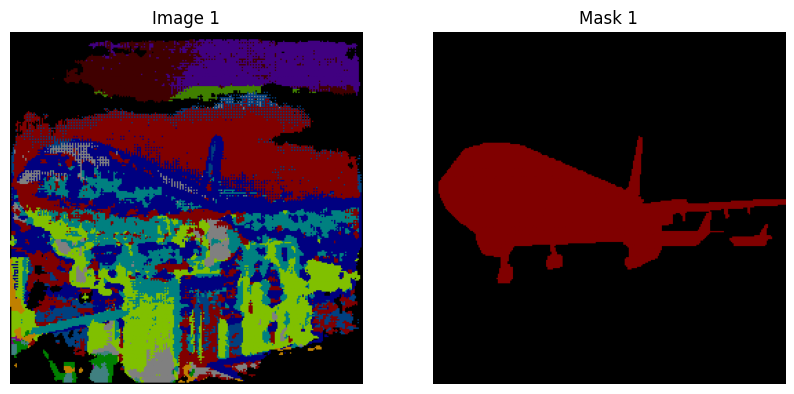

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


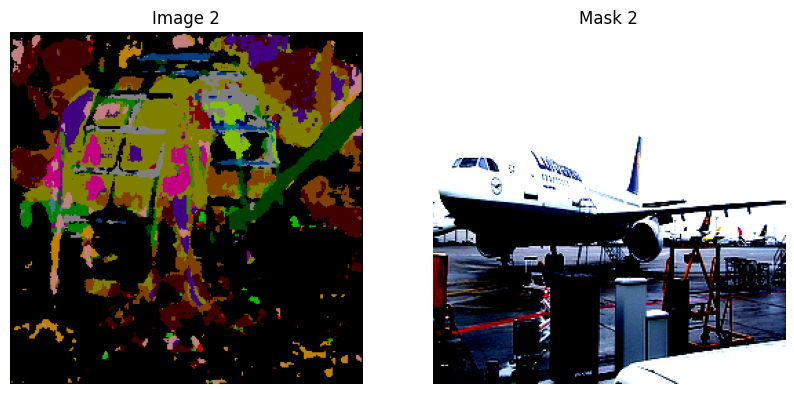

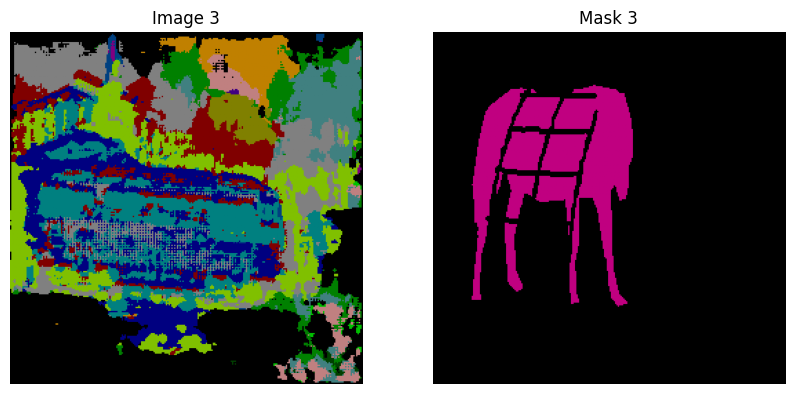

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


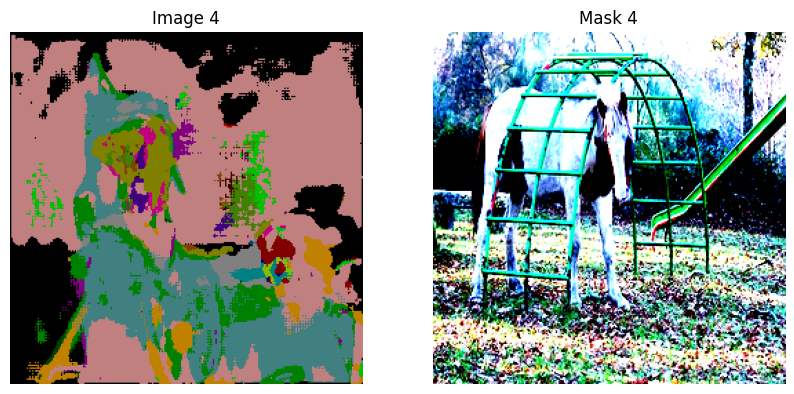

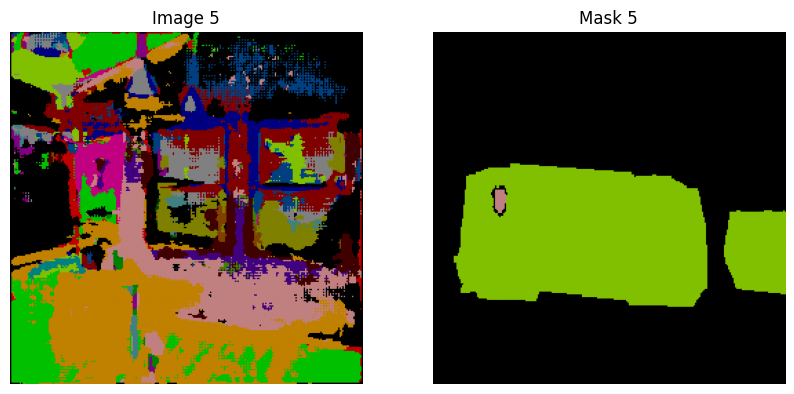

In [19]:
vis_length = 5
imgs = []
masks = []
model = model.to('cpu')
for index, (img, mask) in enumerate(val_loader):
    img = img[0].unsqueeze(0)
    mask = mask[0]
    outs = model(img)  # (NCHW)
    outs = torch.argmax(outs, dim=1)  # NHW
    outs = outs.squeeze(0)
    #print(index, torch.unique(outs, return_counts=True))
    #print(index, torch.unique(mask, return_counts=True))
    mask_decoded = val_dataset.decode_segmap(mask.numpy())
    masks.append(torch.tensor(mask_decoded).permute(2, 0, 1))
    #print(img.shape)
    masks.append(img.squeeze(0))
    outs_decoded = val_dataset.decode_segmap(outs.numpy())
    imgs.append(torch.tensor(outs_decoded).permute(2, 0, 1))
    if len(imgs) == 5:
        break
visualize_image_and_mask_tensors(imgs, masks)